In [7]:
import segmentation_models as sm
from pipeline import Pipeline
import gc
import matplotlib.pyplot as plt

In [3]:
data_dir = "./dataset/"
patch_size = 128  # e.g. 128x128
downsampling = 0.75  # setting this to e.g. 0.5 means images will be loaded as 2x smaller. 1 does nothing.
z_dim = 40   # number of slices in the z direction. max value is 65 - z_start
z_start = 0  # offset of slices in the z direction
batch_size = 16
epochs = 100
steps_per_epoch = 50
val_step = 50

pipeline = Pipeline(data_dir, patch_size, downsampling, z_dim, z_start, batch_size)

volume_1, mask_1, labels_1 = pipeline.load_sample(split="train", index=1)
volume_2, mask_2, labels_2 = pipeline.load_sample(split="train", index=2)
volume_3, mask_3, labels_3 = pipeline.load_sample(split="train", index=3)

gc.collect()
print("Loading complete.")

# NOTE: maybe get rid of
dev_folds = {
    "dev_1": {
        "train_volumes": [volume_1, volume_2],
        "train_labels": [labels_1, labels_2],
        "train_masks": [mask_1, mask_2],
        "validation_volume": volume_3,
        "validation_labels": labels_3,
        "validation_mask": mask_3,
    },
    "dev_2": {
        "train_volumes": [volume_1, volume_3],
        "train_labels": [labels_1, labels_3],
        "train_masks": [mask_1, mask_3],
        "validation_volume": volume_2,
        "validation_labels": labels_2,
        "validation_mask": mask_2,
    },
    "dev_3": {
        "train_volumes": [volume_2, volume_3],
        "train_labels": [labels_2, labels_3],
        "train_masks": [mask_2, mask_3],
        "validation_volume": volume_1,
        "validation_labels": labels_1,
        "validation_mask": mask_1,
    }
}

gc.collect()


Loading 'train/1'...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Loading 'train/2'...


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Loading 'train/3'...


100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


Loading complete.


0

In [5]:
# for now let's only
train_ds, val_ds = pipeline.make_datasets_for_fold(dev_folds['dev_1'])

2023-05-17 13:43:19.996072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 13:43:20.008155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 13:43:20.008393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 13:43:20.011813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

In [19]:
model = sm.Unet(
    'resnet50',
    input_shape=pipeline.get_input_shape(),
    encoder_weights=None,
    classes=1
)
model.load_weights('unet2d_b16_p128_d0.75_zdim40_e100_spe50')

2023-05-17 13:48:47.816589: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28311552 exceeds 10% of free system memory.


In [39]:
batch = train_ds.take(5)

In [40]:
patch = None
label = None

for patch, label in batch:
    break

In [41]:
res = model.predict(patch)

1/1 [==============================] - 0s 71ms/step


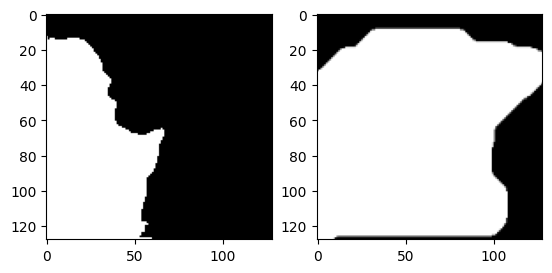

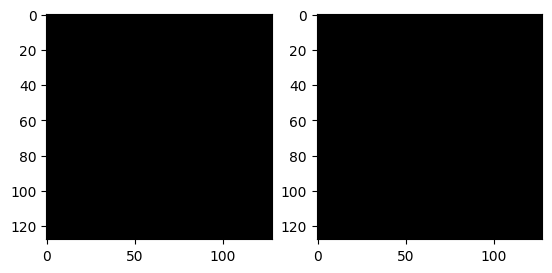

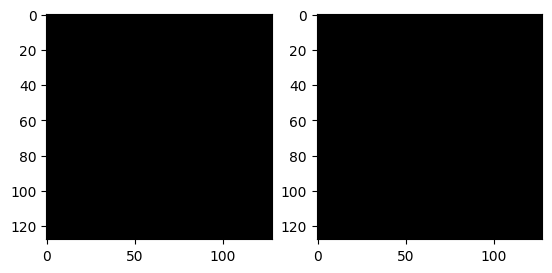

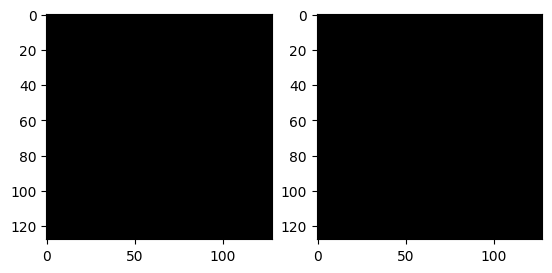

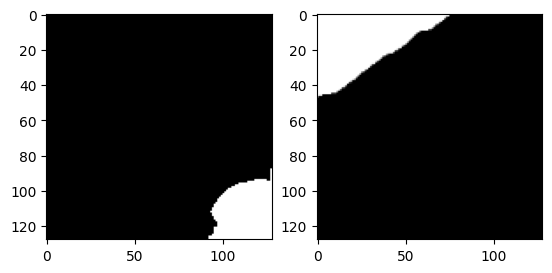

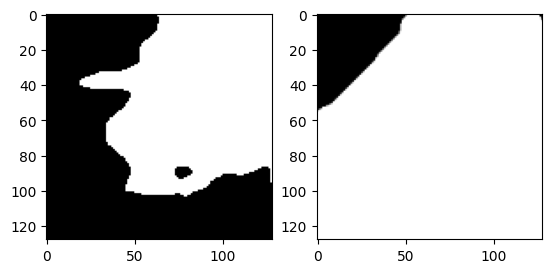

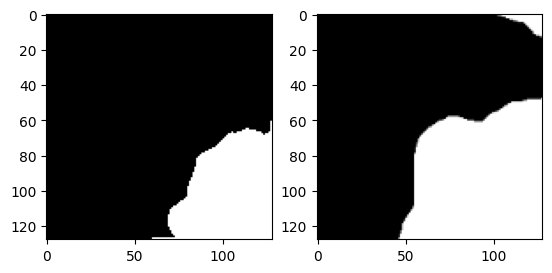

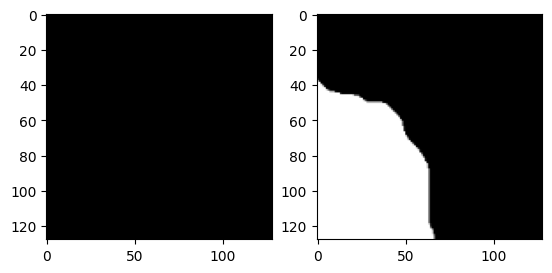

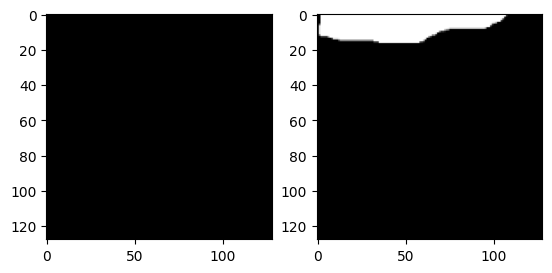

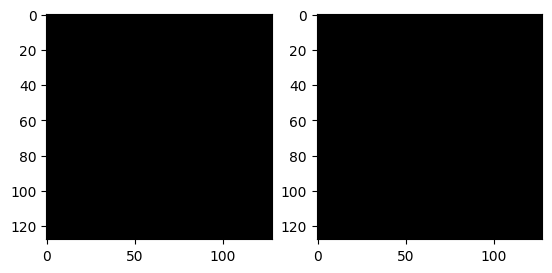

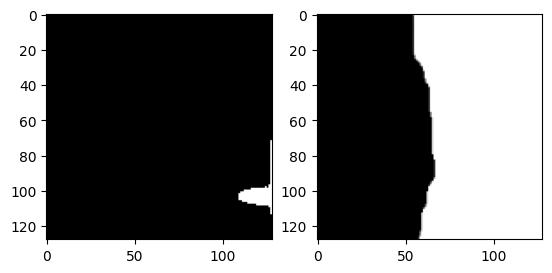

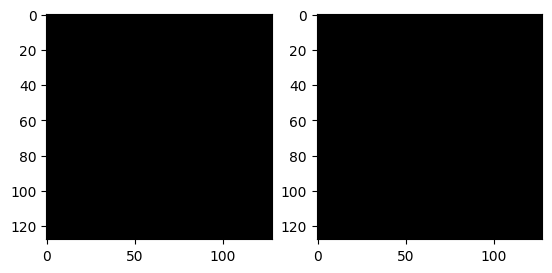

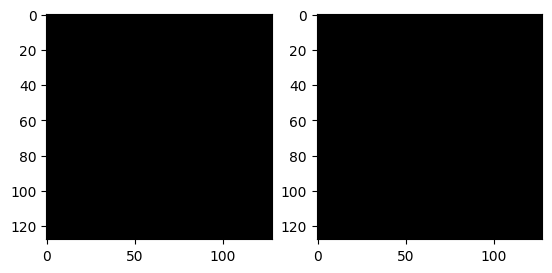

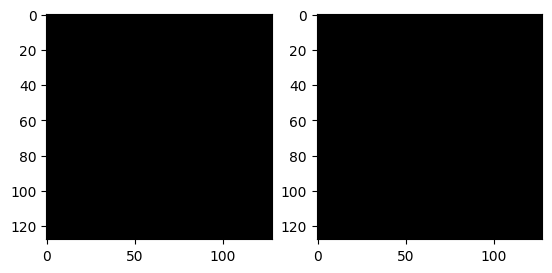

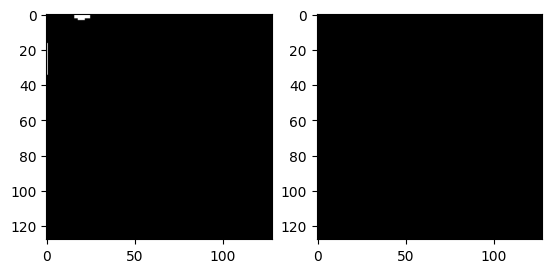

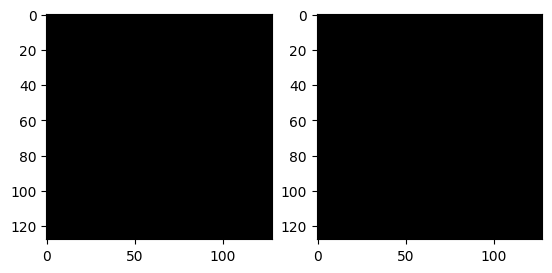

In [43]:
for i in range(res.shape[0]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow((res[i] > 0.3).astype(float), cmap='gray')
    ax[1].imshow(label[i], cmap='gray')